# 17. Parameter fitting on _A. nidulans_ data

## Numerical experiments - Week 21/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Based on the more abundant, time-based data from the _A. niger_ experiments, the most successful models from the previous fitting procedure are used to explain germination data from experiments on _A. nidulans_ conidia [1].

## Prerequisite libraries

In [1]:
using PyPlot
using JLD2
using Statistics
using Distributions
using Revise
using Printf

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
Revise.includet("./datautils.jl")
Revise.includet("./germstats.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis
using .DataUtils
using .GermStats

## 1. Fitting considerations

The _A. nidulans_ dataset does not contain values from which time-dependent evolutions can be reconstructed. Nonetheless, it is noted the measurements are taken at 11 hours of incubation. An alternative study [2] state that the half-saturation time $\tau_g$ for germ tube formation in _A. nidulans_ in a comparable medium is 9.67 hours, the germination rate saturation is 85.46% and the respective design parameter $\nu$ is 6.28. The spore density used in this study is $2.7\times10^5$ spores/mL - at this density, the 11-hour germination rate aligned with the measurements by Herrero-Garcia is estimated to be about 80% [1].

The conflicting findings in the two experiments are rooted in the fact that the 11-hour measurement time in Herrero-Garcia et al [1] is closer to the half-saturation time in the alternative study [2] rather than to a full saturation time. This could suggest that the Dantigny parameters for the data in Herrero-Garcia et al. are different from those in Ijadpanahsaravi et al, likely due to differences in the strain and the cultivation medium used. On the other hand, Herrero-Garcia et al. do not explicitly specify the method used to classify conidia as germinated, which could imply that the percentages also include swollen spores. In any case, it is plausible to assume that the indicated density-dependent germination rates are equilibrium values, i.e. they would not increase significantly under a continued experiment.

With this in consideration, the fitting procedure is required to use **equilibrium probabilities** only. The three models chosen for this are
- inducer-dependent inhibitor threshold and release;
- 2-factor germination with inhibitor-dependent induction threshold;
- independent 2-factor germination with varying permeability.

All models may incorporate a slowly permeating carbon signal, but this assumption becomes irrelevant in the equilibrium limit.

## 2. Equilibrium probabilities

### 2.1. Inducer-dependent inhibitor threshold and release

The time-dependent probability in the first model follows the expression

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, \pi_{\textrm{eff}})}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\pi{(\pi_{\textrm{eff}})}\ f_\xi{(\xi)}\ d{\pi_{\textrm{eff}}}}\ d{\xi}}.
\end{equation}
$$

It was previously shown that, in the equilibrium limit, $\beta=\phi$, so the distribution of $\pi_{\textrm{eff}}$, along with its integral, becomes obsolete. Therefore, the new probability takes the form

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\xi{(\xi)}\ d{\xi}}.
\end{equation}
$$

This is a simple integral which can be solved without resorting to Gauss-Hermite approximation.

### 2.2. Two-factor germination with inhibitor-dependent induction threshold

The time-dependent probability in the second model follows the expression

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\left[\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-kc_{\textrm{in}}{(\xi, \psi)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ d{\psi}}\right] f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

It was previously shown that, in the equilibrium limit, $\beta=\phi$, hence the equilibrium value of $c_{\textrm{in}}^{\textrm{eq}}=\phi\psi$. Since $c_{\textrm{in}}\to 0$ and $\phi$ is only dependent on $\xi$, the integral over $\psi$ can be omitted. In the long-time limit, the carbon source concentration at the receptor proteins equalises to the ambient concentration in the medium, $c_{\textrm{out}}^{\textrm{cs}}$, so the integral over $\kappa$ can be discarded. Thus, the equilibrium signal strength becomes

$$
\begin{equation}
s_{\textrm{eq}}=\frac{c_{\textrm{out}}^{\textrm{cs}}}{c_{\textrm{out}}^{\textrm{cs}}+K_{\textrm{cs}}}.
\end{equation}
$$

Taking this together, the germination probability simplifies to

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\left[\int_0^\infty{\Phi{\left(\frac{s_{\textrm{eq}}-k\phi{(\xi)}\psi-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ d{\psi}}\right]f_\xi{(\xi)}\ d{\xi}}.
\end{equation}
$$

In summary, the residual inhibition still affects both the inhibition-determined germination trigger and the threshold of the inducing signal.

### 2.3. Independent two-factor germination with with varying permeability

The time-dependent probability in the third model follows the expression

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-\mu_\omega}{\sigma_\omega}\right)}\left[1-\Phi{\left(\frac{\beta{(\xi, \alpha, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\alpha{(\alpha)}\ f_\kappa{(\kappa)}\ f_\xi{(\xi)\ d{\alpha}}}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

Since $\beta=\phi$ and $\phi$ is only dependent on $\xi$, the integral over $\alpha$ can be omitted. Similarly, in the long-time limit, the carbon source concentration at the receptor proteins equalises to the ambient concentration in the medium, $c_{\textrm{out}}^{\textrm{cs}}$, making the computations with $t$ and $\kappa$ obsolete. Thus, the germination probability simplifies to

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\Phi{\left(\frac{s_{\textrm{eq}}-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\xi{(\xi)}\ d{\xi}}.
\end{equation}
$$

It should be noted that this probability does not involve any information about the distribution of the permeation constant or the cell wall porosity, so it is identical with the case of a deterministic permeation constant. Since this is a simple integral, it does not require a Gauss-Hermite approximation.

## 3. Data and default parameters

The germination data and the corresponding densities are stored in variables below. The parameter boundaries remain as in the previous parameter fitting procedure. The distribution parameters of the spore radii are set to $\mu_\xi=1.275\ \mu\textrm{m}$ and $\sigma_\xi=0.075\ \mu\textrm{m}$ [3].

The external concentration of the carbon source can be computed by considering that the study uses a minimal medium (MMA) as described in Pontecorvo et al. [4]. The carbon source used in this medium is dextrose, of which $10\ \textrm{g}$ are dilluted in 1 liter of water. Having a molar mass of $180\ \textrm{g/mol}$, the dextrose has a concentration of $10\ \textrm{g}/(180\ \textrm{g/mol}\times 1\ \textrm{L})\approx0.0556\ \textrm{M}$.

In [2]:
# Germination data
densities = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
germ_responses = [0.913, 0.925, 0.83, 0.72, 0.17, 0.08]
conf_intervals = [0.071, 0.074, 0.07, 0.061, 0.003, 0.003]

# Define default parameters globally
def_params = Dict(
    :μ_ξ => 1.275,
    :σ_ξ => 0.075,
    :c₀_cs => 0.00556
)

# Define parameter bounds globally
bounds_narrow = Dict(
    :k => (-6, 6),
    :K_cs => (1e-8, 0.1),
    :μ_γ => (1e-6, 1e-4),
    :δ_γ => (-10, 0),
    :μ_ω => (1e-6, 10.0),
    :δ_ω => (-10, 0),
    :μ_ψ => (1e-5, 1.0),	
    :δ_ψ => (-10, 0)
)

bounds_broad = Dict(
    :k => (-6, 6),
    :K_cs => (1e-8, 0.1),
    :μ_γ => (1e-8, 1e-3),
    :δ_γ => (-10, 0),
    :μ_ω => (1e-6, 10.0),
    :δ_ω => (-10, 0),
    :μ_ψ => (1e-5, 1.0),	
    :δ_ψ => (-10, 0)
)

# Radius distribution
μ_ξ = def_params[:μ_ξ]
σ_ξ = def_params[:σ_ξ]
μ_ξ_log = log(μ_ξ^2 / sqrt(σ_ξ^2 + μ_ξ^2))
σ_ξ_log = sqrt(log(σ_ξ^2 / μ_ξ^2 + 1))
dist_ξ = LogNormal(μ_ξ_log, σ_ξ_log)

LogNormal{Float64}(μ=0.2412190611763456, σ=0.05877273915760268)

## 4. Fitting procedure

### 4.1. Inducer-dependent inhibitor threshold and release

In [36]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("inhibitor", def_params, germ_responses, densities, bounds_narrow, max_steps=max_steps)

jldopen("Data/fit2_inhibitor.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.80 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=0.129746099
1.72 secs, 10 evals, 5 steps, improv/step: 0.800 (last = 0.7500), fitness=0.077594483
2.73 secs, 18 evals, 9 steps, improv/step: 0.889 (last = 1.0000), fitness=0.077594483
3.77 secs, 22 evals, 11 steps, improv/step: 0.818 (last = 0.5000), fitness=0.077594483
4.60 secs, 32 evals, 16 steps, improv/step: 0.750 (last = 0.6000), fitness=0.077594483
5.42 secs, 33 evals, 17 steps, improv/step: 0.765 (last = 1.0000), fitness=0.077594483
6.29 secs, 35 evals, 18 steps, improv/step: 0.722 (last = 0.0000), fitness=0.077594483
8.08 secs, 51 evals, 27 steps, improv/step: 0.667 (last = 0.5556), fitness=0.077594483
8

Dict{Any, Any} with 2 entries:
  :σ_γ => [2.12066e-5]
  :μ_γ => [2.12066e-5]

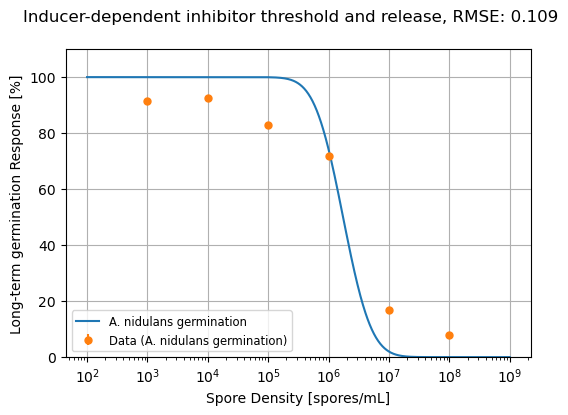

In [ ]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_inhibitor.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses), 2)
errors[1, :, 1] .= conf_intervals
germ_resp_vis = reshape(germ_responses, 1, length(germ_responses)).*100

# Generate test data
density_exp_range = LinRange(2, 9, 1000)
model_densities = 10 .^ density_exp_range
model_responses = zeros(1, length(model_densities))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(6, 4))
model_responses[1, :] .= germ_response_inducer_dep_inhibitor_combined_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ, params_test[:μ_γ], params_test[:σ_γ]).*100
plot_germination_data_fit_densities(densities, germ_resp_vis, model_densities, model_responses, ["A. nidulans germination"], yerr=errors, ax=ax)
fig.suptitle("Inducer-dependent inhibitor threshold and release, RMSE: $(round(rmse, sigdigits=3))")

gcf()

### 4.2. Two-factor germination with inhibitor-dependent induction threshold

In [ ]:
max_steps = 100#00
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer", def_params, germ_responses, densities, bounds_narrow, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps


In [ ]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses), 2)
errors[1, :, 1] .= conf_intervals
germ_resp_vis = reshape(germ_responses, 1, length(germ_responses)).*100

# Generate test data
density_exp_range = LinRange(2, 9, 1000)
model_densities = 10 .^ density_exp_range
model_responses = zeros(1, length(model_densities))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(6, 4))
model_responses[1, :] .= germ_response_inhibitor_dep_inducer_thresh_2_factors_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ, def_params[:c₀_cs],
                                                                                params_test[:K_cs], params_test[:k],
                                                                                params_test[:μ_γ], params_test[:σ_γ],
                                                                                params_test[:μ_ω], params_test[:σ_ω],
                                                                                params_test[:μ_ψ], params_test[:σ_ψ]).*100
plot_germination_data_fit_densities(densities, germ_resp_vis, model_densities, model_responses, ["A. nidulans germination"], yerr=errors, ax=ax)
fig.suptitle("Inducer-dependent inhibitor threshold and release, RMSE: $(round(rmse, sigdigits=3))")

gcf()

### 4.3. Independent two-factor germination with with varying permeability

In [3]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("independent", def_params, germ_responses, densities, bounds_narrow, max_steps=max_steps)

jldopen("Data/fit2_independent.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

[:K_cs, :μ_γ, :δ_γ, :μ_ω, :δ_ω]
Tuple{Real, Real}[(1.0e-8, 0.1), (1.0e-6, 0.0001), (-10, 0), (1.0e-6, 10.0), (-10, 0)]
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.63 secs, 11 evals, 6 steps, improv/step: 1.000 (last = 1.0000), fitness=2.931792424
1.15 secs, 70 evals, 40 steps, improv/step: 0.900 (last = 0.8824), fitness=0.148300866
2.27 secs, 202 evals, 147 steps, improv/step: 0.857 (last = 0.8411), fitness=0.078519717
3.48 secs, 325 evals, 263 steps, improv/step: 0.817 (last = 0.7672), fitness=0.078519717
4.15 secs, 329 evals, 267 steps, improv/step: 0.813 (last = 0.5000), fitness=0.078519717
4.81 secs, 426 evals, 362 steps, improv/step: 0.771 (last = 0.6526), fitness=0.078519717
5.85 secs, 501 evals, 437 steps, improv/step:

Dict{Any, Any} with 5 entries:
  :σ_γ  => [5.01791e-5]
  :K_cs => [0.0142028]
  :μ_ω  => [0.162228]
  :μ_γ  => [5.01791e-5]
  :σ_ω  => [0.159138]

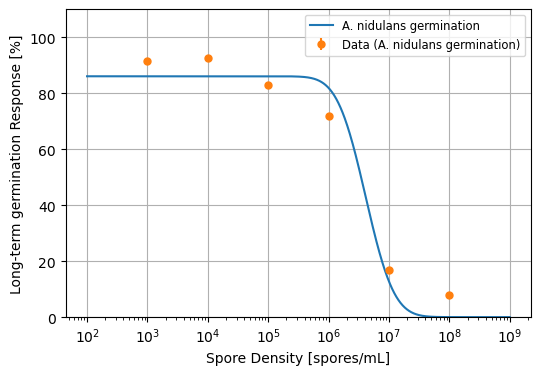

In [4]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_independent.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses), 2)
errors[1, :, 1] .= conf_intervals
germ_resp_vis = reshape(germ_responses, 1, length(germ_responses)).*100

# Generate test data
density_exp_range = LinRange(2, 9, 1000)
model_densities = 10 .^ density_exp_range
model_responses = zeros(1, length(model_densities))

# Plot the fitted model against the germination data
model_responses[1, :] .= germ_response_independent_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ,
                                                        params_test[:c₀_cs], params_test[:K_cs],
                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                        params_test[:μ_ω], params_test[:σ_ω]).*100
plot_germination_data_fit_densities(densities, germ_resp_vis, model_densities, model_responses, ["A. nidulans germination"], yerr=errors)

## References

- [1] Herrero-García, E., Garzia, A., Cordobés, S., Espeso, E.A., & Ugalde, U. (2011). 8-Carbon oxylipins inhibit germination and growth, and stimulate aerial conidiation in Aspergillus nidulans. Fungal biology, 115 4-5, 393-400.
- [2] Ijadpanahsaravi, M., Teertstra, W.R., & Wösten, H.A. (2022). Inter- and intra-species heterogeneity in germination of Aspergillus conidia. Antonie Van Leeuwenhoek, 115, 1151 - 1164.
- [3] Yu, J. (2010). Regulation of Development in Aspergillus nidulans and Aspergillus fumigatus. Mycobiology, 38, 229 - 237.
- [4] Pontecorvo, G., Roper, J.A., Chemmons, L.M., Macdonald, K.D., & Bufton, A. (1953). The genetics of Aspergillus nidulans. Advances in genetics, 5, 141-238 .